# Real-World Graphs

### Libraries

In [1]:
## libs 
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

## Keras
from keras.layers import Lambda, Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

## Basic
from tqdm import tqdm_notebook as tqdm
import argparse
import os
import random
import itertools
import time

# Computation
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import MinMaxScaler


import scipy
from scipy.stats.stats import pearsonr 

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Network Processing
import networkx as nx
from networkx.generators import random_graphs

## node colour
color_map = ["steelblue"]

Using TensorFlow backend.


### Supporting Functions

In [2]:
## supporting functions
from support.preprocessing import sort_adjacency, reshape_A, calculate_A_shape, reconstruct_adjacency, pad_matrix, unpad_matrix, prepare_in_out
from support.metrics import compute_mig, compute_mi
from support.graph_generating import generate_single, generate_manifold, generate_topol_manifold, generate_topol_manifold
from support.latent_space import vis2D, visDistr
from support.comparing import compare_manifold_adjacency, compare_topol_manifold

## graph sampling
from sampling import ForestFire, Metropolis_Hastings, Random_Walk, Snowball, Ties, Base_Samplers

## Loading Graph Data

In [3]:
## load graph data
#e_file = open('data/citeseer/out.citeseer','rb') 
#e_file = open('data/citeseer/out.citeseer','rb') 
#g_complete = nx.read_edgelist(e_file)
#g_complete = nx.convert_node_labels_to_integers(g_complete, first_label=0, ordering='default', label_attribute=None)
#e_file.close()
#g_complete = nx.read_edgelist(e_file)
g_complete = nx.karate_club_graph()

n_complete = len(g_complete)
e_complete = len(g_complete.edges())
a_complete = nx.adjacency_matrix(g_complete)
max_degree = max([d for n, d in g_complete.degree()])

print("number of nodes:", n_complete)
print("number of edges:", e_complete)
print("max_degree:", max_degree)

number of nodes: 34
number of edges: 78
max_degree: 17


## Sample Subgraph

**exact_n:** bfs, forestfire, random_walk_induced_graph_sampling, random_walk_sampling_with_fly_back, adjacency, select

**approx_n:**  snowball, standard_bfs, walk, jump

-- n_max should be >= 30 --
-- function get_graph takes 0.00132 secs --


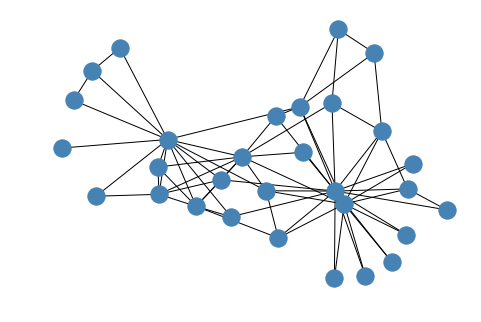

In [30]:
sampleArgs = {"sample": "random_walk_induced_graph_sampling", "jump_bias": "degree", "random_n": 30, "random_p": 0.15, "source_starts": 2, "source_returns": 4, "depth": 2}

##exact_n: forestfire, random_walk_induced_graph_sampling, random_walk_sampling_with_fly_back, adjacency, select
##approx_n: snowball, bfs, walk, jump

def get_graph(sampleArgs,g_complete,a_complete):

    if sampleArgs["sample"] == "forestfire":
        sampler = ForestFire.ForestFire(g_complete,a_complete)
        g = sampler.forestfire(sampleArgs["random_n"])

    if sampleArgs["sample"] == "snowball":
        sampler = Snowball.Snowball(g_complete,a_complete)
        g = sampler.snowball(sampleArgs["source_starts"], sampleArgs["source_returns"])

    if sampleArgs["sample"] == "random_walk_induced_graph_sampling":
        sampler = Random_Walk.Random_Walk(g_complete,a_complete)
        g = sampler.random_walk_induced_graph_sampling(sampleArgs["random_n"])

    if sampleArgs["sample"] == "random_walk_sampling_with_fly_back":
        sampler = Random_Walk.Random_Walk(g_complete,a_complete)
        g = sampler.random_walk_sampling_with_fly_back(sampleArgs["random_n"], sampleArgs["random_p"])
        
    if sampleArgs["sample"] == "standard_bfs":
        sampler = Base_Samplers.Base_Samplers(g_complete,a_complete)
        g = sampler.standard_bfs(sampleArgs["source_starts"], sampleArgs["depth"]) 
        
    if sampleArgs["sample"] == "bfs":
        sampler = Base_Samplers.Base_Samplers(g_complete,a_complete)
        g = sampler.bfs(sampleArgs["random_n"]) 
        
    if sampleArgs["sample"] == "walk":
        sampler = Base_Samplers.Base_Samplers(g_complete,a_complete)
        g = sampler.walk(sampleArgs["source_starts"], sampleArgs["source_returns"], sampleArgs["random_p"])        
        
    if sampleArgs["sample"] == "jump":
        sampler = Base_Samplers.Base_Samplers(g_complete,a_complete)
        g = sampler.jump(sampleArgs["source_starts"], sampleArgs["random_p"], sampleArgs["jump_bias"])
        
    if sampleArgs["sample"] == "adjacency":
        sampler = Base_Samplers.Base_Samplers(g_complete,a_complete)
        g = sampler.adjacency(sampleArgs["random_n"]) 
        
    if sampleArgs["sample"] == "select":
        sampler = Base_Samplers.Base_Samplers(g_complete,a_complete)
        g = sampler.adjacency(sampleArgs["random_n"]) 
    
    return g 

start_time = time.time()
g = get_graph(sampleArgs,g_complete,a_complete)

print("-- n_max should be >=", len(g), "--")
print("-- function get_graph takes %s secs --" % round((time.time() - start_time),  5))

if len(g) <= 200:
    nx.draw(g, node_color = color_map, with_labels = False)

### Generating Training Data

In [31]:
dataArgs = {"n_graphs": 10000, "n_max": 16, "n_lower": 1, "n_upper": 10, "iter_n": True, "fix_n": True, "diag_offset": 0, "diag_value": 1, "clip": True}
                                                                        # none, exact_n, approx_n             #"diag_offset" - 1, 0, 1

def generate_data(dataArgs, sampleArgs, g_complete, a_complete): 
    
    
    if dataArgs["iter_n"] == False:
    
        ## Data ________________________________

        G = np.zeros((dataArgs["n_graphs"], *calculate_A_shape(dataArgs["n_max"], diag_offset = dataArgs["diag_offset"])))

        ## Ground Truth Labels ______________________________

        topol_params = ["#nodes", "#edges", "density", "diameter", "cluster_coef", "assort", "avg_degree"]
        T = np.zeros((dataArgs["n_graphs"], len(topol_params)))

        ## Generate Graph Data_______________________________

        for i in tqdm(range(0,dataArgs["n_graphs"])):

            ## Generate Graph Type ______________________________________________

            g = get_graph(sampleArgs, g_complete, a_complete)

            g, a = sort_adjacency(g)
            a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal
            a_transformed = reshape_A(a, diag_offset = dataArgs["diag_offset"])

            ## Generate Ground Truth features____________________________________

            nodes = len(g)
            edges = g.number_of_edges()

            density = nx.density(g)

            if nx.is_connected(g):
                diameter = nx.diameter(g)
            else:
                diameter = -1

            cluster_coef = nx.average_clustering(g)

            if g.number_of_edges() > 0:
                assort = nx.degree_assortativity_coefficient(g, x='out', y='in')
            else:
                assort = 0

            avg_degree = sum(i for i in nx.degree_centrality(g).values()) / len(nx.degree_centrality(g).keys())


            ## toDO: add more graph topologies

            ## Build Data Arrays___________________________________________________

            G[i] = a_transformed

            T[i,0] = nodes
            T[i,1] = edges
            T[i,2] = density
            T[i,3] = diameter
            T[i,4] = cluster_coef
            T[i,5] = assort
            T[i,6] = avg_degree
            
            
            
    elif dataArgs["iter_n"] == True:      ## iterate different n to generate range
    
        ## Data ________________________________

        G = np.zeros((dataArgs["n_graphs"], *calculate_A_shape(dataArgs["n_max"], diag_offset = dataArgs["diag_offset"])))

        ## Ground Truth Labels ______________________________

        topol_params = ["#nodes", "#edges", "density", "diameter", "cluster_coef", "assort", "avg_degree"]
        T = np.zeros((dataArgs["n_graphs"], len(topol_params)))

        ## Generate Graph Data_______________________________
        
        # generate N range
        if dataArgs["n_upper"] <= dataArgs["n_max"]:
            N = np.linspace(dataArgs["n_lower"], dataArgs["n_upper"], dataArgs["n_graphs"], dtype = int)
        else:
            sys.exit("dataArgs[n_upper] > dataArgs[n_max]")

        for i, n in enumerate(tqdm(N)):

            ## Generate Graph Type ______________________________________________

            sampleArgs["random_n"] = n
            sampleArgs["source_starts"] = n
                
            g = get_graph(sampleArgs, g_complete, a_complete)

            g, a = sort_adjacency(g)
            a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal
            a_transformed = reshape_A(a, diag_offset = dataArgs["diag_offset"])

            ## Generate Ground Truth features____________________________________

            nodes = len(g)
            edges = g.number_of_edges()

            density = nx.density(g)

            if nx.is_connected(g):
                diameter = nx.diameter(g)
            else:
                diameter = -1

            cluster_coef = nx.average_clustering(g)

            if g.number_of_edges() > 0:
                assort = nx.degree_assortativity_coefficient(g, x='out', y='in')
            else:
                assort = 0

            avg_degree = sum(i for i in nx.degree_centrality(g).values()) / len(nx.degree_centrality(g).keys())


            ## toDO: add more graph topologies

            ## Build Data Arrays___________________________________________________

            G[i] = a_transformed

            T[i,0] = nodes
            T[i,1] = edges
            T[i,2] = density
            T[i,3] = diameter
            T[i,4] = cluster_coef
            T[i,5] = assort
            T[i,6] = avg_degree



    ## Input and Output Size ___________________________________________________________

    T, input_shape, output_shape = prepare_in_out(T, dataArgs["diag_offset"], calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"]))
    print("input_shape:", input_shape, ", output_shape:", output_shape)
    
    return G,T,topol_params,input_shape,output_shape
    
G, T, topol_params, input_shape, output_shape = generate_data(dataArgs, sampleArgs, g_complete, a_complete)


input_shape: (136,) , output_shape: 136


# beta-VAE (MLP, Conv)

## Build Model

In [32]:
modelArgs = {"nn_architecture": "mlp", "param_loss": False, "latent_dim": 2, "filters": 16, "kernel_size": 3, "input_shape": input_shape, "output_shape": output_shape}

In [33]:
# network parameters

# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps

def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon



## MODEL ______________________________________________________________

## Multi-layer Perceptron without convolutions__________________________________

if modelArgs["nn_architecture"] == "mlp":

    ## 1) build encoder model
    inputs = Input(shape=modelArgs["input_shape"], name='encoder_input')
    x = Dense(128, activation='relu')(inputs)
    x = Dense(64, activation='relu')(x)
    z_mean = Dense(modelArgs["latent_dim"], name='z_mean')(x)
    z_log_var = Dense(modelArgs["latent_dim"], name='z_log_var')(x)

    ## 2) build decoder model
    latent_inputs = Input(shape=(modelArgs["latent_dim"],), name='z_sampling')
    y = Dense(64, activation='relu')(latent_inputs)
    y = Dense(128, activation='relu')(y)
    outputs = Dense(modelArgs["output_shape"], activation='sigmoid')(y)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(modelArgs["latent_dim"],), name='z')([z_mean, z_log_var])


    ## INSTANTIATE ________________________________________________

    ## 1) instantiate encoder model
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()
    #plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

    ## 2) instantiate decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')
    decoder.summary()
    #plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

    ## 3) instantiate VAE model
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='vae_graph')
    #vae.summary()



## Convolutional Neural Network_________________________________

if modelArgs["nn_architecture"] == "2D_conv":


    ## 1) build encoder model____________________________________

    inputs = Input(shape=modelArgs["input_shape"], name='encoder_input')
    x = inputs

    for i in range(2):
        modelArgs['filters'] *= 2
        x = Conv2D(filters=modelArgs['filters'], kernel_size=modelArgs['kernel_size'], activation='relu', strides=2, padding='same')(x)

    # shape info needed to build decoder model
    shape = K.int_shape(x)

    # generate latent vector Q(z|X)
    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)
    z_mean = Dense(modelArgs["latent_dim"], name='z_mean')(x)
    z_log_var = Dense(modelArgs["latent_dim"], name='z_log_var')(x)



    ## 2) build decoder model____________________________________

    latent_inputs = Input(shape=(modelArgs["latent_dim"],), name='z_sampling')
    x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
    x = Reshape((shape[1], shape[2], shape[3]))(x)

    for i in range(2):
        x = Conv2DTranspose(filters=modelArgs['filters'], kernel_size=modelArgs['kernel_size'], activation='relu', strides=2, padding='same')(x)
        modelArgs['filters'] //= 2

    outputs = Conv2DTranspose(filters=1, kernel_size=modelArgs['kernel_size'], activation='sigmoid', padding='same', name='decoder_output')(x)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(modelArgs["output_shape"],), name='z')([z_mean, z_log_var])



    ## INSTANTIATE___________________________________

    ## 1) instantiate encoder model    
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()
    #plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)


    ## 2) instantiate decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')
    decoder.summary()
    #plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)


    ## 3) instantiate VAE model
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='conv_vae')
    #vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 136)          0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 128)          17536       encoder_input[0][0]              
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 64)           8256        dense_11[0][0]                   
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            130         dense_12[0][0]                   
__________________________________________________________________________________________________
z_log_var 

## Train Model

In [34]:
trainArgs = {"beta": 2, "loss": "mse", "weights": "train", "early_stop": 3, "batch_size": 64, "epochs": 10, "data_split": 0.2}

In [35]:
## MLP: beta =
## CNN: beta = (latent 2 / beta 25)

## Train and Validation Split _______________________________________________

x_train, x_test, y_train, y_test = train_test_split(G, T, test_size= trainArgs["data_split"], random_state=1, shuffle=True)

models = (encoder, decoder)
data = (x_test, y_test)


## VAE loss = mse_loss or xent_loss + kl_loss_______________________

if trainArgs["loss"] == "mse":
    
    if modelArgs["nn_architecture"] == "mlp":
        reconstruction_loss = mse(inputs, outputs)
        reconstruction_loss *= modelArgs["input_shape"]
        
    if modelArgs["nn_architecture"] == "2D_conv":
        reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
        reconstruction_loss *= modelArgs["input_shape"][0] * modelArgs["input_shape"][1]
        
if trainArgs["loss"] == "binary_crossentropy":
    
    if modelArgs["nn_architecture"] == "mlp":
        reconstruction_loss = binary_crossentropy(inputs, outputs)
        reconstruction_loss *= modelArgs["input_shape"]
        
    if modelArgs["nn_architecture"] == "2D_conv":
        reconstruction_loss = binary_crossentropy(K.flatten(inputs),K.flatten(outputs))
        reconstruction_loss *= modelArgs["input_shape"][0] * modelArgs["input_shape"][1]



## LOSS _____________________________________________

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + (trainArgs["beta"] * kl_loss))
vae.add_loss(vae_loss)
vae.compile(optimizer='adam', metrics=['accuracy'])
vae.summary()
#plot_model(vae,to_file='vae_mlp.png',show_shapes=True)



## TRAIN______________________________________________

# load the autoencoder weights

if trainArgs["weights"] == "load":
    
    vae.load_weights("models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5")

# train the autoencoder

elif trainArgs["weights"] == "train":
    
    # Set callback functions to early stop training and save the best model so far
    callbacks = [EarlyStopping(monitor='val_loss', patience=trainArgs["early_stop"]), ModelCheckpoint(filepath="models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5", save_best_only=True)]
    
    vae.fit(x_train, epochs=trainArgs["epochs"], batch_size=trainArgs["batch_size"], callbacks=callbacks, validation_data=(x_test, None))
    vae.save_weights("models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5")



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 136)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 26052     
_________________________________________________________________
decoder (Model)              (None, 136)               26056     
Total params: 52,108
Trainable params: 52,108
Non-trainable params: 0
_________________________________________________________________
Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 1s 90us/step - loss: 11.1826 - val_loss: 5.0422
Epoch 2/10
8000/8000 [==============================] - 0s 27us/step - loss: 5.0257 - val_loss: 4.8906
Epoch 3/10
8000/8000 [==============================] - 0s 33us/step - loss: 4.8643 - val_loss: 4.6949
Epoch 4/10
8000/8000 [======================

# Latent Space Analysis

# Encoder

## Iterate through single data dimension and oberseve single latent space dimension  

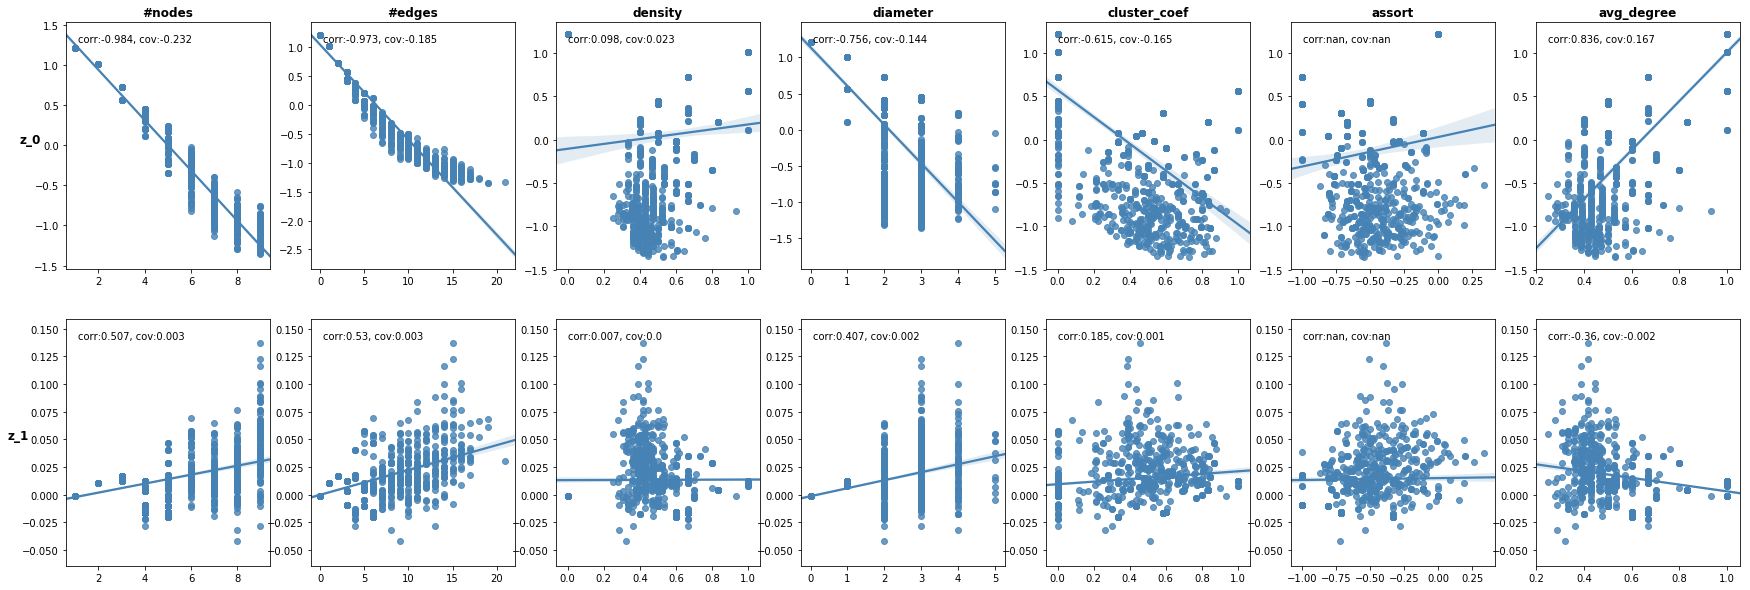

In [36]:
analyzeArgs = {"n_graphs": 1000, "metric": "mig"}

def latent_space_feature_correlation(analyzeArgs, modelArgs, models, data, topol_params, batch_size=128,model_name="vae_graph"):

    encoder, decoder = models  # trained models
    x_test, y_test = data      # data
                
    G = x_test[:analyzeArgs["n_graphs"],:]
    T = y_test[:analyzeArgs["n_graphs"]]
    
    ## ENCODER - 2D Digit Classes ______________________________________________

    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(G, batch_size = batch_size)


    ## Graph Topologies________________________________________________________
    
    ## Visualize Latent Variables x Topological Parameters 
    
    if z_mean.shape[-1] == 1:  # 1 latent variable

        fig, ax = plt.subplots(nrows= z_mean.shape[1] , ncols= len(topol_params), figsize=(20,10))
        
        for latent_z, row in enumerate(ax):        

                ## toDO: change sorting
                y = z_mean[:,0]
                x = T[:,latent_z]
                sns.regplot(x, y, color="steelblue", ax=row)


                ## compute correlation and standardized covariance
                corr = round(pearsonr(x,y)[0],3)
                cov = round(np.cov(x, y)[0][1]/max(x),3)
                row.annotate("corr:"+str(corr)+", cov:"+str(cov), xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points')



        ## add row and column titles _____________________

        cols = [t for t in topol_params]

        for axis, col in zip(ax[:], cols):
            axis.set_title(col, fontweight='bold')



            
    ## Visualize Latent Variables x Topological Parameters 
    
    if z_mean.shape[-1] >= 2:  # 1 latent variable   

        fig, ax = plt.subplots(nrows= z_mean.shape[-1] , ncols= len(topol_params), figsize=(30,10))

        for latent_z, row in enumerate(ax):        
            for feature, col in enumerate(row):

                ## toDO: change sorting
                y = z_mean[:,latent_z]
                x = T[:,feature]
                sns.regplot(x, y, color="steelblue", ax=col)


                ## compute correlation and standardized covariance
                corr = round(pearsonr(x,y)[0],3)
                cov = round(np.cov(x, y)[0][1]/max(x),3)
                col.annotate("corr:"+str(corr)+", cov:"+str(cov), xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points')



        ## add row and column titles _____________________

        rows = ['z_{}'.format(row) for row in range(z_mean.shape[-1])]
        cols = [t for t in topol_params]

        for axis, col in zip(ax[0], cols):
            axis.set_title(col, fontweight='bold')

        for axis, row in zip(ax[:,0], rows):
            axis.set_ylabel(row, rotation=0, size='large', fontweight='bold')

        

## PLOT RESULTS ________________________________________

latent_space_feature_correlation(analyzeArgs, modelArgs, models, data, topol_params, batch_size=trainArgs["batch_size"], model_name="vae_mlp")

## Visualize the Latent Space in 2D

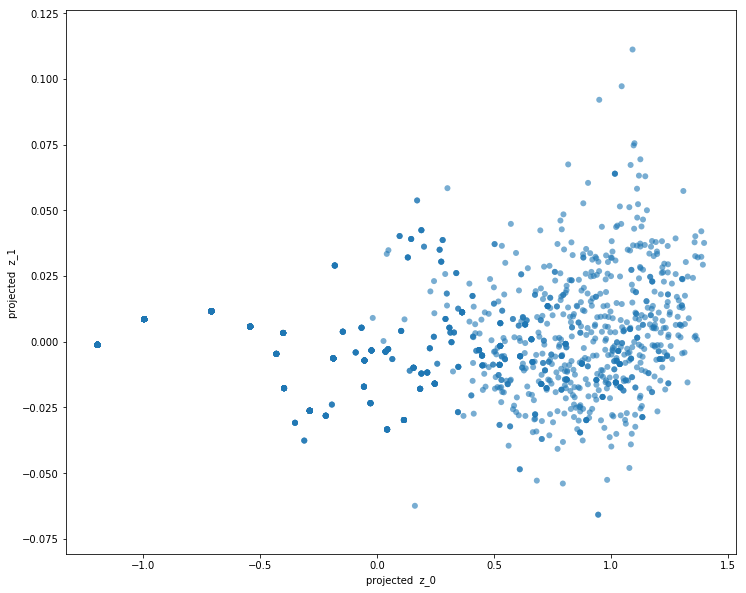

In [37]:
analyzeArgs = {"save_plots": False}
vis2D(analyzeArgs, modelArgs, models, data, batch_size=trainArgs["batch_size"], model_name="vae_mlp")

## Visualize Latent Generative Distribution

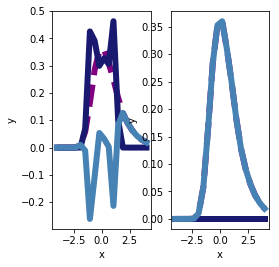

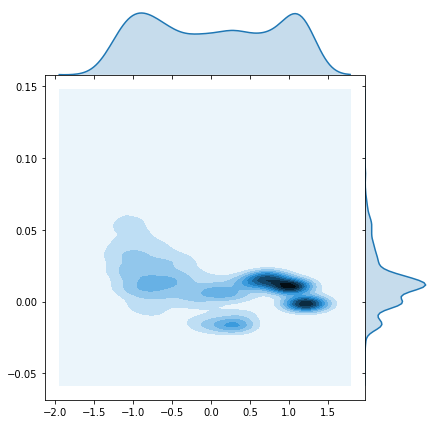

In [38]:
analyzeArgs = {"z": [0,1]}
visDistr(modelArgs, analyzeArgs, models,data,trainArgs["batch_size"])

# Decoder

## Generate a Single Graph Instance

latent dimensions: 2


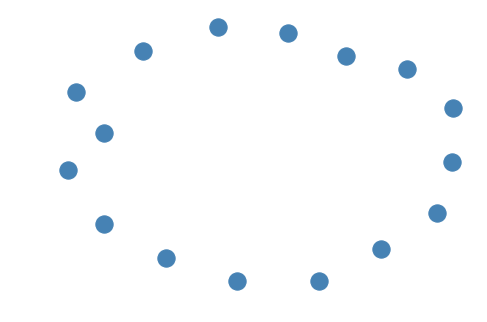

In [39]:
analyzeArgs = {"activations": [+20,+20], "z": [0,1]}
generate_single(analyzeArgs, modelArgs, dataArgs, models, color_map)

## Generate Interpolated Manifold from Latent Space

latent dimensions: 2


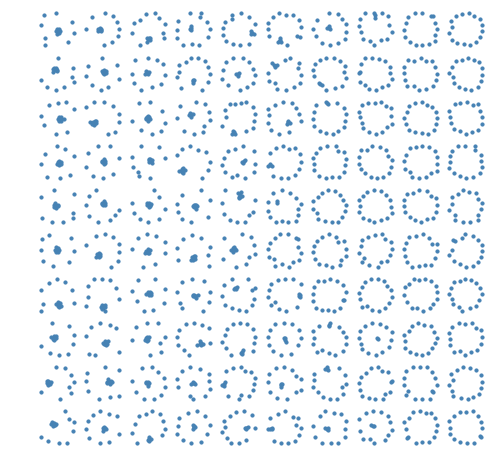

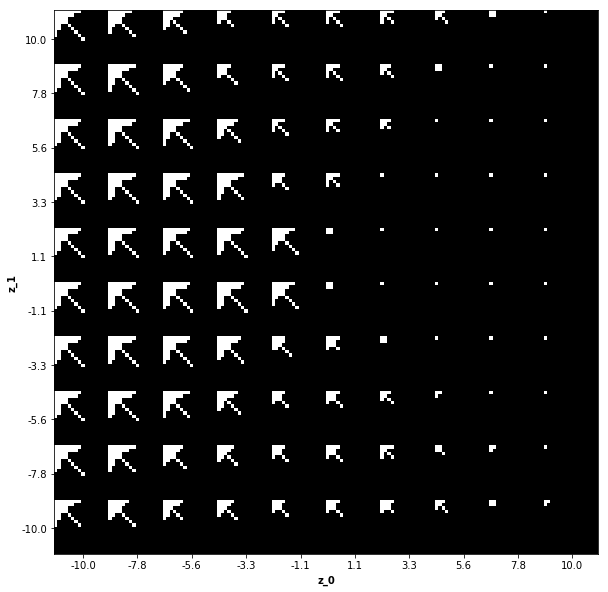

In [40]:
# range, normal, z
analyzeArgs = {"z": [0,1], "sample": "range", "act_range": [-10, 10], "act_scale": 3, "size_of_manifold": 10, "save_plots": False}
generate_manifold(analyzeArgs, modelArgs, dataArgs, models, data, color_map, batch_size=trainArgs["batch_size"])

latent dimensions: 2


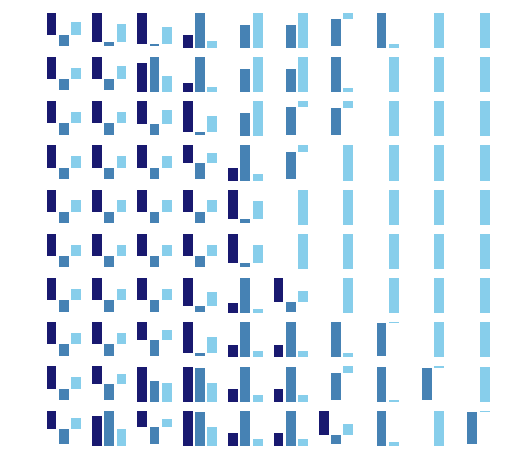

In [41]:
## "topol", "distr", "nodes_edges"
analyzeArgs["plot"] = "topol" 
generate_topol_manifold(analyzeArgs, modelArgs, dataArgs, models, data, color_map, batch_size=trainArgs["batch_size"])
## cluster_coef", "assort", "avg_degree"

# Compare with Original Graph

## Prepare Original Graph

In [16]:
sampleArgs["random_n"] = dataArgs["n_max"]
sampleArgs["source_starts"] = dataArgs["n_max"]

def get_original_graph(sampleArgs, g_complete, a_complete):
    g_subset = get_graph(sampleArgs, g_complete, a_complete)
    g_subset, a_subset = sort_adjacency(g_subset)
    a_subset = pad_matrix(a_subset, dataArgs["n_max"], dataArgs["diag_value"])
    return g_subset, a_subset

## Adjacency, Precision and Recall

In [42]:
from support.preprocessing import reconstruct_adjacency, unpad_matrix
from sklearn.metrics import precision_recall_fscore_support
import networkx as nx
import numpy as np
from matplotlib import pylab as plt
import os


## DECODER - Latent Space Interpolation____________________________

def compare_manifold_adjacency(g_original, a_original, analyzeArgs, modelArgs, dataArgs, models, data, color_map, batch_size=128):

    print("latent dimensions:", modelArgs["latent_dim"])

    if modelArgs["param_loss"]:
        encoder, graph_decoder, param_decoder = models  # trained models
    else:
        encoder, graph_decoder = models  # trained models

    x_test, y_test = data

    # display a 2D plot of the digit classes in the latent space
    z_mean, z_log_var, z = encoder.predict(x_test, batch_size)

    ## Latent Space Dimension is 1 ______________________

    if modelArgs["latent_dim"] == 1:

        ## 1) create adjacency plots__________________________________________

        # display a 30x30 2D manifold of digits
        n = dataArgs["n_max"]  # number of nodes
        figure = np.zeros((1 * n, analyzeArgs["size_of_manifold"] * n, 3))

        # linearly spaced coordinates corresponding to the 2D plot
        # of digit classes in the latent space
        if analyzeArgs["sample"] == "z":
            grid_x = np.sort(np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][0]]),
                                              np.mean(np.exp(z_log_var[:, analyzeArgs["z"][0]])),
                                              analyzeArgs["size_of_manifold"]))
        elif analyzeArgs["sample"] == "range":
            grid_x = np.linspace(analyzeArgs["act_range"][0], analyzeArgs["act_range"][1],
                                 analyzeArgs["size_of_manifold"])
        elif analyzeArgs["sample"] == "normal":
            grid_x = np.sort(
                np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][0]]), 1, analyzeArgs["size_of_manifold"]))

        z_sample = np.zeros(modelArgs["latent_dim"])
        z_sample = np.reshape(z_sample, (1, modelArgs["latent_dim"]))

        ## 2) create graph plots_______________________________________________

        fig, axs = plt.subplots(1, analyzeArgs["size_of_manifold"], figsize=(10, 10))
        # fig.subplots_adjust(hspace = .5, wspace=.001)
        axs = axs.ravel()

        for j, xi in enumerate(grid_x):

            z_sample[0][0] = xi ** analyzeArgs["act_scale"]
            x_decoded = graph_decoder.predict(z_sample)

            comparison_matrix = np.zeros((n, n, 3))
            reconstructed_a = reconstruct_adjacency(x_decoded, dataArgs["clip"], dataArgs["diag_offset"])

            # reconstruct graph
            g = nx.from_numpy_matrix(unpad_matrix(reconstructed_a, dataArgs["diag_value"], dataArgs["fix_n"]))

            # metrics per graph
            metrics = {"tp": 0, "fp": 0, "tn": 0, "fn": 0}

            for x in range(0, n):
                for y in range(0, n):

                    if a_original[x, y] == reconstructed_a[x, y] and a_original[x, y] == 1:  # correct
                        comparison_matrix[x, y, :] = [0, 90, 0]  # green
                        if x != y:
                            metrics["tp"] = metrics.get("tp") + 1

                    elif a_original[x, y] == reconstructed_a[x, y] and a_original[x, y] == 0:  # correct
                        comparison_matrix[x, y, :] = [255, 255, 255]  # black
                        if x != y:
                            metrics["tn"] = metrics.get("tn") + 1

                    elif a_original[x, y] != reconstructed_a[x, y] and a_original[x, y] == 1:  # underfit

                        if x < len(g) and y < len(g):
                            comparison_matrix[x, y, :] = [90, 0, 0]  # red   # missed
                            if x != y:
                                metrics["fn"] = metrics.get("fn") + 1
                        else:
                            comparison_matrix[x, y, :] = [150, 150, 150]  # grey   # not possible since too small

                    elif a_original[x, y] != reconstructed_a[x, y] and a_original[x, y] == 0:  # overfit
                        comparison_matrix[x, y, :] = [70, 70, 0]  # yellow
                        if x != y:
                            metrics["fp"] = metrics.get("fp") + 1

            ## 1) create adjacency plots_____________________________________

            figure[0:n, j * n: (j + 1) * n, :] = comparison_matrix

            ## 2) create metric plots _______________________________________________

            acc = (metrics["tp"] + metrics["tn"]) / (metrics["tn"] + metrics["fn"] + metrics["tp"] + metrics["fp"])

            if (metrics["tp"] + metrics["fp"]) > 0:
                prec = (metrics["tp"]) / (metrics["tp"] + metrics["fp"])
            else:
                prec = 0

            if (metrics["tp"] + metrics["fn"]) > 0:
                recall = (metrics["tp"]) / (metrics["tp"] + metrics["fn"])
            else:
                recall = 0

            if (recall + prec) > 0:
                f1 = 2 * (recall * prec) / (recall + prec)
            else:
                f1 = 0

            y_pos = np.arange(3)
            final_metrics = [prec, recall, f1]
            colors = ["skyblue", "skyblue", "midnightblue"]

            jx = np.unravel_index(j, axs.shape)
            plt.sca(axs[jx])

            plt.bar(y_pos, final_metrics, color=colors, align='center')
            plt.plot([-1, 3], [0.25, 0.25], color='grey', linestyle='dashed')
            plt.plot([-1, 3], [0.5, 0.5], color='grey', linestyle='dashed')
            plt.plot([-1, 3], [0.75, 0.75], color='grey', linestyle='dashed')

            axs[jx].set_axis_off()
            axs[jx].set(ylabel='z_0')

        start_range = n // 2
        end_range = (analyzeArgs["size_of_manifold"] - 1) * n + start_range + 1
        pixel_range = np.arange(start_range, end_range, n)
        sample_range_x = np.round(grid_x, 1)

        # Plot_____________________________

        plt.figure(figsize=(10, 10))
        plt.xticks(pixel_range, sample_range_x)
        plt.xlabel("z_0", fontweight='bold')
        plt.imshow((figure * 255).astype(np.uint8))
        plt.show()

    ## Latent Space Dimension is 2 ______________________

    if modelArgs["latent_dim"] == 2:

        ## 1) create adjacency plots_______________________________________________

        # display a 30x30 2D manifold of digits
        n = dataArgs["n_max"]  # number of nodes
        figure = np.zeros((analyzeArgs["size_of_manifold"] * n, analyzeArgs["size_of_manifold"] * n, 3))

        # linearly spaced coordinates corresponding to the 2D plot
        # of digit classes in the latent space
        if analyzeArgs["sample"] == "z":
            grid_x = np.sort(np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][0]]),
                                              np.mean(np.exp(z_log_var[:, analyzeArgs["z"][0]])),
                                              analyzeArgs["size_of_manifold"]))
            grid_y = np.sort(np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][1]]),
                                              np.mean(np.exp(z_log_var[:, analyzeArgs["z"][1]])),
                                              analyzeArgs["size_of_manifold"]))
        elif analyzeArgs["sample"] == "range":
            grid_x = np.linspace(analyzeArgs["act_range"][0], analyzeArgs["act_range"][1],
                                 analyzeArgs["size_of_manifold"])
            grid_y = np.linspace(analyzeArgs["act_range"][0], analyzeArgs["act_range"][1],
                                 analyzeArgs["size_of_manifold"])[::-1]  ## revert
        elif analyzeArgs["sample"] == "normal":
            grid_x = np.sort(
                np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][0]]), 1, analyzeArgs["size_of_manifold"]))
            grid_y = np.sort(
                np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][1]]), 1, analyzeArgs["size_of_manifold"]))

        ## 2) create metric plots _______________________________________________

        fig, axs = plt.subplots(analyzeArgs["size_of_manifold"], analyzeArgs["size_of_manifold"], figsize=(10, 10))

        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):

                xi_value = xi ** analyzeArgs["act_scale"]
                yi_value = yi ** analyzeArgs["act_scale"]

                z_sample = np.array([[xi_value, yi_value]])
                x_decoded = graph_decoder.predict(z_sample)

                comparison_matrix = np.zeros((n, n, 3))
                reconstructed_a = reconstruct_adjacency(x_decoded, dataArgs["clip"], dataArgs["diag_offset"])

                # reconstruct graph
                g = nx.from_numpy_matrix(unpad_matrix(reconstructed_a, dataArgs["diag_value"], dataArgs["fix_n"]))

                # metrics per graph
                metrics = {"tp": 0, "fp": 0, "tn": 0, "fn": 0}
                
                for x in range(0, n):
                    for y in range(0, n):

                        if a_original[x, y] == reconstructed_a[x, y] and a_original[x, y] == 1:  # correct
                            comparison_matrix[x, y, :] = [0, 90, 0]  # green
                            if x != y:
                                metrics["tp"] = metrics.get("tp") + 1

                        elif a_original[x, y] == reconstructed_a[x, y] and a_original[x, y] == 0:  # correct
                            comparison_matrix[x, y, :] = [255, 255, 255]  # black
                            if x != y:
                                metrics["tn"] = metrics.get("tn") + 1

                        elif a_original[x, y] != reconstructed_a[x, y] and a_original[x, y] == 1:  # underfit

                            if x < len(g) and y < len(g):
                                comparison_matrix[x, y, :] = [90, 0, 0]  # red   # missed
                                if x != y:
                                    metrics["fn"] = metrics.get("fn") + 1
                            else:
                                comparison_matrix[x, y, :] = [150, 150, 150]  # grey   # not possible since too small

                        elif a_original[x, y] != reconstructed_a[x, y] and a_original[x, y] == 0:  # overfit
                            comparison_matrix[x, y, :] = [70, 70, 0]  # yellow
                            if x != y:
                                metrics["fp"] = metrics.get("fp") + 1

                ## 1) create adjacency plots_____________________________________

                figure[i * n: (i + 1) * n, j * n: (j + 1) * n, :] = comparison_matrix

                ## 2) create metric plots _______________________________________________

                acc = (metrics["tp"] + metrics["tn"]) / (metrics["tn"] + metrics["fn"] + metrics["tp"] + metrics["fp"])

                if (metrics["tp"] + metrics["fp"]) > 0:
                    prec = (metrics["tp"]) / (metrics["tp"] + metrics["fp"])
                else:
                    prec = 0

                if (metrics["tp"] + metrics["fn"]) > 0:
                    recall = (metrics["tp"]) / (metrics["tp"] + metrics["fn"])
                else:
                    recall = 0

                if (recall + prec) > 0:
                    f1 = 2 * (recall * prec) / (recall + prec)
                else:
                    f1 = 0

                y_pos = np.arange(3)
                final_metrics = [prec, recall, f1]
                colors = ["skyblue", "skyblue", "midnightblue"]

                plt.sca(axs[i, j])
                plt.bar(y_pos, final_metrics, color=colors, align='center')
                plt.plot([-1, 3], [0.25, 0.25], color='grey', linestyle='dashed')
                plt.plot([-1, 3], [0.5, 0.5], color='grey', linestyle='dashed')
                plt.plot([-1, 3], [0.75, 0.75], color='grey', linestyle='dashed')
                axs[i, j].set_axis_off()

        start_range = n // 2
        end_range = (analyzeArgs["size_of_manifold"] - 1) * n + start_range + 1
        pixel_range = np.arange(start_range, end_range, n)
        sample_range_x = np.round(grid_x, 1)
        sample_range_y = np.round(grid_y, 1)

        # Plot_____________________________

        plt.figure(figsize=(10, 10))
        plt.xticks(pixel_range, sample_range_x)
        plt.yticks(pixel_range, sample_range_y)
        plt.xlabel("z_0", fontweight='bold')
        plt.ylabel("z_1", fontweight='bold')
        plt.imshow((figure * 255).astype(np.uint8))
        plt.show()

    ## Latent Space Dimension is larger than 2 ______________________

    if modelArgs["latent_dim"] > 2:

        z_sample = np.zeros(modelArgs["latent_dim"])
        z_sample = np.reshape(z_sample, (1, modelArgs["latent_dim"]))

        ## fill unobserved dimensions with mean of latent variable dimension
        for dim in range(0, len(z_sample[0])):
            z_sample[0][dim] = np.mean(z_mean[:, dim])

        ## 1) create adjacency plots_______________________________________________

        # display a 30x30 2D manifold of digits
        n = dataArgs["n_max"]  # number of nodes
        figure = np.zeros((analyzeArgs["size_of_manifold"] * n, analyzeArgs["size_of_manifold"] * n, 3))

        # linearly spaced coordinates corresponding to the 2D plot
        # of digit classes in the latent space
        if analyzeArgs["sample"] == "z":
            grid_x = np.sort(np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][0]]),
                                              np.mean(np.exp(z_log_var[:, analyzeArgs["z"][0]])),
                                              analyzeArgs["size_of_manifold"]))
            grid_y = np.sort(np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][1]]),
                                              np.mean(np.exp(z_log_var[:, analyzeArgs["z"][1]])),
                                              analyzeArgs["size_of_manifold"]))
        elif analyzeArgs["sample"] == "range":
            grid_x = np.linspace(analyzeArgs["act_range"][0], analyzeArgs["act_range"][1],
                                 analyzeArgs["size_of_manifold"])
            grid_y = np.linspace(analyzeArgs["act_range"][0], analyzeArgs["act_range"][1],
                                 analyzeArgs["size_of_manifold"])[::-1]  ## revert
        elif analyzeArgs["sample"] == "normal":
            grid_x = np.sort(
                np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][0]]), 1, analyzeArgs["size_of_manifold"]))
            grid_y = np.sort(
                np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][1]]), 1, analyzeArgs["size_of_manifold"]))

        ## 2) create metric plots _______________________________________________

        fig, axs = plt.subplots(analyzeArgs["size_of_manifold"], analyzeArgs["size_of_manifold"], figsize=(10, 10))

        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):

                z_sample[0][analyzeArgs["z"][0]] = xi ** analyzeArgs["act_scale"]
                z_sample[0][analyzeArgs["z"][1]] = xi ** analyzeArgs["act_scale"]
                x_decoded = graph_decoder.predict(z_sample)

                comparison_matrix = np.zeros((n, n, 3))
                reconstructed_a = reconstruct_adjacency(x_decoded, dataArgs["clip"], dataArgs["diag_offset"])

                # reconstruct graph
                g = nx.from_numpy_matrix(unpad_matrix(reconstructed_a, dataArgs["diag_value"], dataArgs["fix_n"]))

                # metrics per graph
                metrics = {"tp": 0, "fp": 0, "tn": 0, "fn": 0}

                for x in range(0, n):
                    for y in range(0, n):

                        if a_original[x, y] == reconstructed_a[x, y] and a_original[x, y] == 1:  # correct
                            comparison_matrix[x, y, :] = [0, 90, 0]  # green
                            if x != y:
                                metrics["tp"] = metrics.get("tp") + 1

                        elif a_original[x, y] == reconstructed_a[x, y] and a_original[x, y] == 0:  # correct
                            comparison_matrix[x, y, :] = [255, 255, 255]  # black
                            if x != y:
                                metrics["tn"] = metrics.get("tn") + 1

                        elif a_original[x, y] != reconstructed_a[x, y] and a_original[x, y] == 1:  # underfit

                            if x < len(g) and y < len(g):
                                comparison_matrix[x, y, :] = [90, 0, 0]  # red   # missed
                                if x != y:
                                    metrics["fn"] = metrics.get("fn") + 1
                            else:
                                comparison_matrix[x, y, :] = [150, 150, 150]  # grey   # not possible since too small

                        elif a_original[x, y] != reconstructed_a[x, y] and a_original[x, y] == 0:  # overfit
                            comparison_matrix[x, y, :] = [70, 70, 0]  # yellow
                            if x != y:
                                metrics["fp"] = metrics.get("fp") + 1

                ## 1) create adjacency plots_____________________________________

                figure[i * n: (i + 1) * n, j * n: (j + 1) * n, :] = comparison_matrix

                ## 2) create metric plots _______________________________________________

                acc = (metrics["tp"] + metrics["tn"]) / (metrics["tn"] + metrics["fn"] + metrics["tp"] + metrics["fp"])

                if (metrics["tp"] + metrics["fp"]) > 0:
                    prec = (metrics["tp"]) / (metrics["tp"] + metrics["fp"])
                else:
                    prec = 0

                if (metrics["tp"] + metrics["fn"]) > 0:
                    recall = (metrics["tp"]) / (metrics["tp"] + metrics["fn"])
                else:
                    recall = 0

                if (recall + prec) > 0:
                    f1 = 2 * (recall * prec) / (recall + prec)
                else:
                    f1 = 0

                y_pos = np.arange(3)
                final_metrics = [prec, recall, f1]
                colors = ["skyblue", "skyblue", "midnightblue"]

                plt.sca(axs[i, j])
                plt.bar(y_pos, final_metrics, color=colors, align='center')
                plt.plot([-1, 3], [0.25, 0.25], color='grey', linestyle='dashed')
                plt.plot([-1, 3], [0.5, 0.5], color='grey', linestyle='dashed')
                plt.plot([-1, 3], [0.75, 0.75], color='grey', linestyle='dashed')
                axs[i, j].set_axis_off()

        start_range = n // 2
        end_range = (analyzeArgs["size_of_manifold"] - 1) * n + start_range + 1
        pixel_range = np.arange(start_range, end_range, n)
        sample_range_x = np.round(grid_x, 1)
        sample_range_y = np.round(grid_y, 1)

        # Plot_____________________________

        plt.figure(figsize=(10, 10))
        plt.xticks(pixel_range, sample_range_x)
        plt.yticks(pixel_range, sample_range_y)
        plt.xlabel("z_" + str(analyzeArgs["z"][0]), fontweight='bold')
        plt.ylabel("z_" + str(analyzeArgs["z"][1]), fontweight='bold')
        plt.imshow((figure * 255).astype(np.uint8))
        plt.show()












def compare_topol_manifold(g_original, a_original, analyzeArgs, modelArgs, dataArgs, models, data, color_map,
                           batch_size=128):
    print("latent dimensions:", modelArgs["latent_dim"])

    encoder, graph_decoder = models  # trained models
    x_test, y_test = data

    # display a 2D plot of the digit classes in the latent space
    z_mean, z_log_var, z = encoder.predict(x_test, batch_size)

    ## Latent Space Dimension is 1 ______________________

    if modelArgs["latent_dim"] == 1:

        # linearly spaced coordinates corresponding to the 2D plot
        # of digit classes in the latent space
        if analyzeArgs["sample"] == "z":
            grid_x = np.sort(np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][0]]),
                                              np.mean(np.exp(z_log_var[:, analyzeArgs["z"][0]])),
                                              analyzeArgs["size_of_manifold"]))
        elif analyzeArgs["sample"] == "range":
            grid_x = np.linspace(analyzeArgs["act_range"][0], analyzeArgs["act_range"][1],
                                 analyzeArgs["size_of_manifold"])
        elif analyzeArgs["sample"] == "normal":
            grid_x = np.sort(
                np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][0]]), 1, analyzeArgs["size_of_manifold"]))

        z_sample = np.zeros(modelArgs["latent_dim"])
        z_sample = np.reshape(z_sample, (1, modelArgs["latent_dim"]))

        ## 1) create graph topol plots_______________________________________________

        fig, axs = plt.subplots(1, analyzeArgs["size_of_manifold"], figsize=(10, 10))
        # fig.subplots_adjust(hspace = .5, wspace=.001)
        axs = axs.ravel()

        degree_sequence_original = sorted([d for n, d in g_original.degree()], reverse=True)  # degree sequence

        for j, xi in enumerate(grid_x):

            z_sample[0][0] = xi ** analyzeArgs["act_scale"]
            x_decoded = graph_decoder.predict(z_sample)

            ## reconstruct upper triangular adjacency matrix
            reconstructed_a = reconstruct_adjacency(x_decoded, dataArgs["clip"], dataArgs["diag_offset"])

            # reconstruct graph
            reconstructed_a = unpad_matrix(reconstructed_a, dataArgs["diag_value"], dataArgs["fix_n"])
            g = nx.from_numpy_matrix(reconstructed_a)

            ## Obtain Graph Topologies____________________________________

            density_original = nx.density(g_original)
            density = nx.density(g)

            diameter_original = nx.diameter(g_original)
            if len(g) > 0:
                if nx.is_connected(g):
                    diameter = nx.diameter(g)
            else:
                diameter = -1

            cluster_coef_original = nx.average_clustering(g_original)
            if len(g) > 0:
                cluster_coef = nx.average_clustering(g)
            else:
                cluster_coef = 0

            assort_original = nx.degree_assortativity_coefficient(g_original, x='out', y='in')
            if len(g) > 0:
                if g.number_of_edges() > 0:
                    assort = nx.degree_assortativity_coefficient(g, x='out', y='in')
            else:
                assort = 0

            edges_original = g_original.number_of_edges()
            if len(g) > 0:
                edges = g.number_of_edges()
            else:
                edges = 0

            avg_degree_original = sum(i for i in nx.degree_centrality(g_original).values()) / len(
                nx.degree_centrality(g_original).keys())
            if len(g) > 0:
                avg_degree = sum(i for i in nx.degree_centrality(g).values()) / len(nx.degree_centrality(g).keys())
            else:
                avg_degree = 0

            # compute index for the subplot, and set this subplot as current
            jx = np.unravel_index(j, axs.shape)
            plt.sca(axs[jx])

            ## create the plot_____________________________________________

            if analyzeArgs["plot"] == "topol":

                topol = ("cluster_coef", "assort", "avg_degree")
                colors = ["midnightblue", "steelblue", "skyblue"]

                y_pos = np.arange(len(topol))
                topol_values = [cluster_coef, assort, avg_degree]
                topol_values_original = [cluster_coef_original, assort_original, avg_degree_original]
                # plt.bar(y_pos, topol_values_original, color=colors, fill=False, align='center')
                plt.hlines(topol_values_original[0], -0.5, 0.5)
                plt.hlines(topol_values_original[1], 0.5, 1.5)
                plt.hlines(topol_values_original[2], 1.5, 2.5)
                plt.bar(y_pos, topol_values, color=colors, align='center')
                plt.xticks(y_pos, topol)


            elif analyzeArgs["plot"] == "topol_diff":

                topol = ("cluster_coef", "assort", "avg_degree")
                # pal = sns.color_palette("RdYlGn", len(topol))

                topol_values = [cluster_coef, assort, avg_degree]
                topol_values_original = [cluster_coef_original, assort_original, avg_degree_original]

                x_pos = np.arange(len(topol))
                topol_differences = (np.asarray(topol_values_original) - np.asarray(topol_values))

                # color = [(x/10.0, x/20.0, 0.75) for x in 10*(np.abs(topol_differences) / np.sum(np.abs(topol_differences)))] # <-- Quick gradient example along the Red/Green dimensions.

                from matplotlib import cm

                # colors = cm.YlOrRd(np.abs(topol_differences) / float(max(np.abs(topol_differences))))
                # colors = cm.Blues(np.abs(topol_differences) / float(max(np.abs(topol_differences))))
                colors = cm.RdYlGn_r(np.abs(topol_differences) / float(max(np.abs(topol_differences))))
                # colors = colors[::-1]
                plt.bar(range(len(topol_differences)), topol_differences, color=colors)


            elif analyzeArgs["plot"] == "distr":

                degree_sequence = sorted([d for n, d in g.degree()], reverse=True)  # degree sequence

                degree_sequence = np.asarray(degree_sequence) / sum(degree_sequence)  # normalize degree sequence
                degree_sequence = np.repeat(degree_sequence, (len(degree_sequence_original) / len(
                    degree_sequence)))  # stretch normalize degree sequence to match length
                degree_sequence_original = np.asarray(degree_sequence_original) / sum(
                    degree_sequence_original)  # normalize original degree sequence

                plt.plot(degree_sequence_original, color="midnightblue", linestyle='dashed')
                plt.plot(degree_sequence, color="steelblue")

            axs[jx].set_axis_off()

        # import matplotlib.patches as mpatches

        # density_patch = mpatches.Patch(color='midnightblue', label='density')
        # cluster_patch = mpatches.Patch(color='blue', label='cluster_coef')
        # assort_patch = mpatches.Patch(color='steelblue', label='assort')
        # avg_degree_patch = mpatches.Patch(color='skyblue', label='avg_degree')
        # axs[-1].legend(handles=[density_patch, cluster_patch, assort_patch, avg_degree_patch])

    if modelArgs["latent_dim"] == 2:

        # linearly spaced coordinates corresponding to the 2D plot
        # of digit classes in the latent space
        if analyzeArgs["sample"] == "z":
            grid_x = np.sort(np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][0]]),
                                              np.mean(np.exp(z_log_var[:, analyzeArgs["z"][0]])),
                                              analyzeArgs["size_of_manifold"]))
            grid_y = np.sort(np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][1]]),
                                              np.mean(np.exp(z_log_var[:, analyzeArgs["z"][1]])),
                                              analyzeArgs["size_of_manifold"]))
        elif analyzeArgs["sample"] == "range":
            grid_x = np.linspace(analyzeArgs["act_range"][0], analyzeArgs["act_range"][1],
                                 analyzeArgs["size_of_manifold"])
            grid_y = np.linspace(analyzeArgs["act_range"][0], analyzeArgs["act_range"][1],
                                 analyzeArgs["size_of_manifold"])[::-1]  ## revert
        elif analyzeArgs["sample"] == "normal":
            grid_x = np.sort(
                np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][0]]), 1, analyzeArgs["size_of_manifold"]))
            grid_y = np.sort(
                np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][1]]), 1, analyzeArgs["size_of_manifold"]))

        ## 1) create graph topol plots_______________________________________________

        fig, axs = plt.subplots(analyzeArgs["size_of_manifold"], analyzeArgs["size_of_manifold"], figsize=(8, 8))
        # fig.subplots_adjust(hspace = .5, wspace=.001)

        degree_sequence_original = sorted([d for n, d in g_original.degree()], reverse=True)  # degree sequence

        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):

                xi_value = xi ** analyzeArgs["act_scale"]
                yi_value = yi ** analyzeArgs["act_scale"]

                z_sample = np.array([[xi_value, yi_value]])
                x_decoded = graph_decoder.predict(z_sample)

                ## reconstruct upper triangular adjacency matrix
                reconstructed_a = reconstruct_adjacency(x_decoded, dataArgs["clip"], dataArgs["diag_offset"])

                ## reconstruct graph
                reconstructed_a = unpad_matrix(reconstructed_a, dataArgs["diag_value"], dataArgs["fix_n"])
                g = nx.from_numpy_matrix(reconstructed_a)

                ## Obtain Graph Topologies____________________________________

                density_original = nx.density(g_original)
                density = nx.density(g)

                diameter_original = nx.diameter(g_original)
                if len(g) > 0:
                    if nx.is_connected(g):
                        diameter = nx.diameter(g)
                else:
                    diameter = -1

                cluster_coef_original = nx.average_clustering(g_original)
                if len(g) > 0:
                    cluster_coef = nx.average_clustering(g)
                else:
                    cluster_coef = 0

                assort_original = nx.degree_assortativity_coefficient(g_original, x='out', y='in')
                if len(g) > 0:
                    if g.number_of_edges() > 0:
                        assort = nx.degree_assortativity_coefficient(g, x='out', y='in')
                else:
                    assort = 0

                edges_original = g_original.number_of_edges()
                if len(g) > 0:
                    edges = g.number_of_edges()
                else:
                    edges = 0

                avg_degree_original = sum(i for i in nx.degree_centrality(g_original).values()) / len(
                    nx.degree_centrality(g_original).keys())
                if len(g) > 0:
                    avg_degree = sum(i for i in nx.degree_centrality(g).values()) / len(nx.degree_centrality(g).keys())
                else:
                    avg_degree = 0

                # compute index for the subplot, and set this subplot as current
                plt.sca(axs[i, j])

                ## create the plot_____________________________________________

                if analyzeArgs["plot"] == "topol":

                    topol = ("cluster_coef", "assort", "avg_degree")
                    colors = ["midnightblue", "steelblue", "skyblue"]

                    y_pos = np.arange(len(topol))
                    topol_values = [cluster_coef, assort, avg_degree]
                    topol_values_original = [cluster_coef_original, assort_original, avg_degree_original]
                    # plt.bar(y_pos, topol_values_original, color=colors, fill=False, align='center')
                    plt.hlines(topol_values_original[0], -0.5, 0.5)
                    plt.hlines(topol_values_original[1], 0.5, 1.5)
                    plt.hlines(topol_values_original[2], 1.5, 2.5)
                    plt.bar(y_pos, topol_values, color=colors, align='center')
                    plt.xticks(y_pos, topol)


                elif analyzeArgs["plot"] == "topol_diff":

                    topol = ("cluster_coef", "assort", "avg_degree")
                    # pal = sns.color_palette("RdYlGn", len(topol))

                    topol_values = [cluster_coef, assort, avg_degree]
                    topol_values_original = [cluster_coef_original, assort_original, avg_degree_original]

                    x_pos = np.arange(len(topol))
                    topol_differences = (np.asarray(topol_values_original) - np.asarray(topol_values))

                    # color = [(x/10.0, x/20.0, 0.75) for x in 10*(np.abs(topol_differences) / np.sum(np.abs(topol_differences)))] # <-- Quick gradient example along the Red/Green dimensions.

                    from matplotlib import cm

                    # colors = cm.YlOrRd(np.abs(topol_differences) / float(max(np.abs(topol_differences))))
                    # colors = cm.Blues(np.abs(topol_differences) / float(max(np.abs(topol_differences))))
                    colors = cm.RdYlGn_r(np.abs(topol_differences) / float(max(np.abs(topol_differences))))
                    # colors = colors[::-1]
                    plt.bar(range(len(topol_differences)), topol_differences, color=colors)


                elif analyzeArgs["plot"] == "distr":

                    degree_sequence = sorted([d for n, d in g.degree()], reverse=True)  # degree sequence

                    degree_sequence = np.asarray(degree_sequence) / sum(degree_sequence)  # normalize degree sequence
                    degree_sequence = np.repeat(degree_sequence, (len(degree_sequence_original) / len(
                        degree_sequence)))  # stretch normalize degree sequence to match length
                    degree_sequence_original = np.asarray(degree_sequence_original) / sum(
                        degree_sequence_original)  # normalize original degree sequence

                    plt.plot(degree_sequence_original, color="midnightblue", linestyle='dashed')
                    plt.plot(degree_sequence, color="steelblue")

                axs[i, j].set_axis_off()

    if modelArgs["latent_dim"] > 2:

        z_sample = np.zeros(modelArgs["latent_dim"])
        z_sample = np.reshape(z_sample, (1, modelArgs["latent_dim"]))

        ## fill unobserved dimensions with mean of latent variable dimension
        for dim in range(0, len(z_sample[0])):
            z_sample[0][dim] = np.mean(z_mean[:, dim])

        # linearly spaced coordinates corresponding to the 2D plot
        # of digit classes in the latent space
        if analyzeArgs["sample"] == "z":
            grid_x = np.sort(np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][0]]),
                                              np.mean(np.exp(z_log_var[:, analyzeArgs["z"][0]])),
                                              analyzeArgs["size_of_manifold"]))
            grid_y = np.sort(np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][1]]),
                                              np.mean(np.exp(z_log_var[:, analyzeArgs["z"][1]])),
                                              analyzeArgs["size_of_manifold"]))
        elif analyzeArgs["sample"] == "range":
            grid_x = np.linspace(analyzeArgs["act_range"][0], analyzeArgs["act_range"][1],
                                 analyzeArgs["size_of_manifold"])
            grid_y = np.linspace(analyzeArgs["act_range"][0], analyzeArgs["act_range"][1],
                                 analyzeArgs["size_of_manifold"])[::-1]  ## revert
        elif analyzeArgs["sample"] == "normal":
            grid_x = np.sort(
                np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][0]]), 1, analyzeArgs["size_of_manifold"]))
            grid_y = np.sort(
                np.random.normal(np.mean(z_mean[:, analyzeArgs["z"][1]]), 1, analyzeArgs["size_of_manifold"]))

        ## 1) create graph topol plots_______________________________________________

        fig, axs = plt.subplots(analyzeArgs["size_of_manifold"], analyzeArgs["size_of_manifold"], figsize=(10, 10))
        # fig.subplots_adjust(hspace = .5, wspace=.001)

        degree_sequence_original = sorted([d for n, d in g_original.degree()], reverse=True)  # degree sequence

        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):

                z_sample[0][analyzeArgs["z"][0]] = xi ** analyzeArgs["act_scale"]
                z_sample[0][analyzeArgs["z"][1]] = xi ** analyzeArgs["act_scale"]
                x_decoded = graph_decoder.predict(z_sample)

                ## reconstruct upper triangular adjacency matrix
                reconstructed_a = reconstruct_adjacency(x_decoded, dataArgs["clip"], dataArgs["diag_offset"])

                ## reconstruct graph
                reconstructed_a = unpad_matrix(reconstructed_a, dataArgs["diag_value"], dataArgs["fix_n"])
                g = nx.from_numpy_matrix(reconstructed_a)

                ## Obtain Graph Topologies____________________________________

                density_original = nx.density(g_original)
                density = nx.density(g)

                diameter_original = nx.diameter(g_original)
                if len(g) > 0:
                    if nx.is_connected(g):
                        diameter = nx.diameter(g)
                else:
                    diameter = -1

                cluster_coef_original = nx.average_clustering(g_original)
                if len(g) > 0:
                    cluster_coef = nx.average_clustering(g)
                else:
                    cluster_coef = 0

                assort_original = nx.degree_assortativity_coefficient(g_original, x='out', y='in')
                if len(g) > 0:
                    if g.number_of_edges() > 0:
                        assort = nx.degree_assortativity_coefficient(g, x='out', y='in')
                else:
                    assort = 0

                edges_original = g_original.number_of_edges()
                if len(g) > 0:
                    edges = g.number_of_edges()
                else:
                    edges = 0

                avg_degree_original = sum(i for i in nx.degree_centrality(g_original).values()) / len(
                    nx.degree_centrality(g_original).keys())
                if len(g) > 0:
                    avg_degree = sum(i for i in nx.degree_centrality(g).values()) / len(nx.degree_centrality(g).keys())
                else:
                    avg_degree = 0

                # compute index for the subplot, and set this subplot as current
                plt.sca(axs[i, j])

                ## create the plot_____________________________________________

                ## create the plot_____________________________________________

                if analyzeArgs["plot"] == "topol":

                    topol = ("cluster_coef", "assort", "avg_degree")
                    colors = ["midnightblue", "steelblue", "skyblue"]

                    y_pos = np.arange(len(topol))
                    topol_values = [cluster_coef, assort, avg_degree]
                    topol_values_original = [cluster_coef_original, assort_original, avg_degree_original]
                    # plt.bar(y_pos, topol_values_original, color=colors, fill=False, align='center')
                    plt.hlines(topol_values_original[0], -0.5, 0.5)
                    plt.hlines(topol_values_original[1], 0.5, 1.5)
                    plt.hlines(topol_values_original[2], 1.5, 2.5)
                    plt.bar(y_pos, topol_values, color=colors, align='center')
                    plt.xticks(y_pos, topol)

                elif analyzeArgs["plot"] == "topol_diff":

                    topol = ("cluster_coef", "assort", "avg_degree")
                    # pal = sns.color_palette("RdYlGn", len(topol))

                    topol_values = [cluster_coef, assort, avg_degree]
                    topol_values_original = [cluster_coef_original, assort_original, avg_degree_original]

                    x_pos = np.arange(len(topol))
                    topol_differences = (np.asarray(topol_values_original) - np.asarray(topol_values))

                    # color = [(x/10.0, x/20.0, 0.75) for x in 10*(np.abs(topol_differences) / np.sum(np.abs(topol_differences)))] # <-- Quick gradient example along the Red/Green dimensions.

                    from matplotlib import cm

                    # colors = cm.YlOrRd(np.abs(topol_differences) / float(max(np.abs(topol_differences))))
                    # colors = cm.Blues(np.abs(topol_differences) / float(max(np.abs(topol_differences))))
                    colors = cm.RdYlGn_r(np.abs(topol_differences) / float(max(np.abs(topol_differences))))
                    # colors = colors[::-1]
                    plt.bar(range(len(topol_differences)), topol_differences, color=colors)

                elif analyzeArgs["plot"] == "distr":

                    degree_sequence = sorted([d for n, d in g.degree()], reverse=True)  # degree sequence

                    degree_sequence = np.asarray(degree_sequence) / sum(degree_sequence)  # normalize degree sequence
                    degree_sequence = np.repeat(degree_sequence, (len(degree_sequence_original) / len(
                        degree_sequence)))  # stretch normalize degree sequence to match length
                    degree_sequence_original = np.asarray(degree_sequence_original) / sum(
                        degree_sequence_original)  # normalize original degree sequence

                    plt.plot(degree_sequence_original, color="midnightblue", linestyle='dashed')
                    plt.plot(degree_sequence, color="steelblue")

                axs[i, j].set_axis_off()



latent dimensions: 2


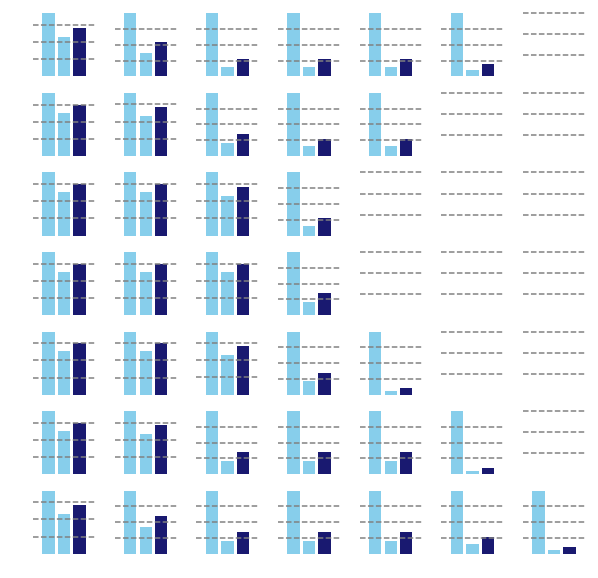

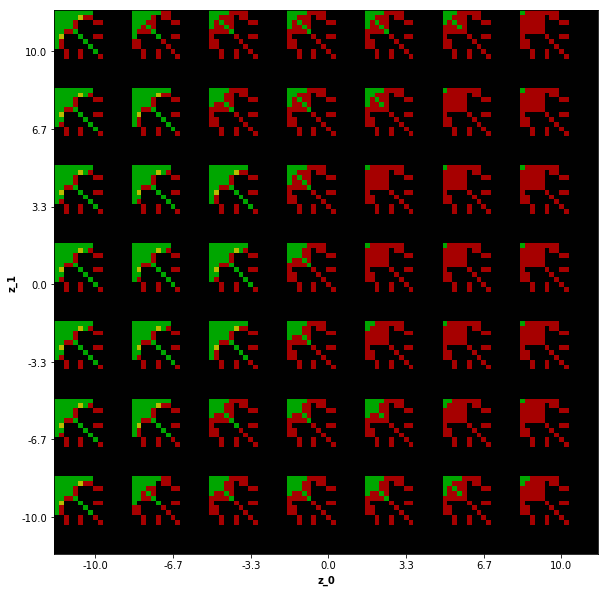

In [43]:
g_subset, a_subset = get_original_graph(sampleArgs, g_complete, a_complete)
analyzeArgs = {"z": [0,1], "sample": "range", "act_range": [-10, 10], "act_scale": 5, "size_of_manifold": 7}
compare_manifold_adjacency(g_subset, a_subset, analyzeArgs, modelArgs, dataArgs, models, data, color_map, batch_size=trainArgs["batch_size"])

## Compare Topology and Distribution

latent dimensions: 2


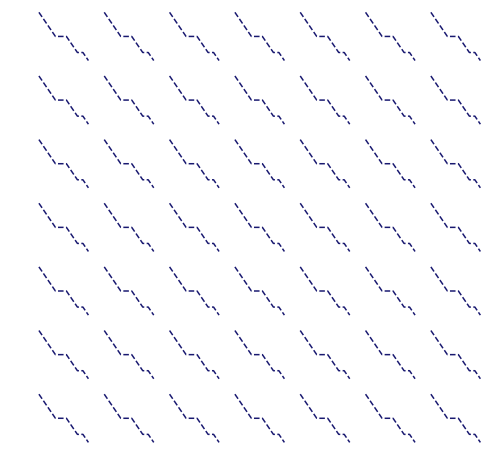

In [44]:
g_subset, a_subset = get_original_graph(sampleArgs, g_complete, a_complete)

## "topol", "topol_diff", "distr"
analyzeArgs["plot"] = "distr"
compare_topol_manifold(g_subset, a_subset, analyzeArgs, modelArgs, dataArgs, models, data, color_map, batch_size=trainArgs["batch_size"])
## cluster_coef", "assort", "avg_degree"